<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisDroneDataset(CustomDataset):

    CLASSES = ('car', 'truck', 'bus')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'VisDronetxt')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/retinanet/retinanet_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [3]:
# 从./configs/retinanet/retinanet_r50_caffe_fpn_1x_coco.py脚本中导入，以下且修改部分信息如model.bbox_head.num_classes=3
# 在faster rcnn中为model.roi_head.bbox_head.num_classes=3

from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VisDroneDataset'
cfg.data_root = 'data/coco/'

cfg.data.train.type = 'VisDroneDataset'
cfg.data.train.data_root ='data/coco/'
cfg.data.train.ann_file = 'ImageSets/Main/train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'VisDroneDataset'
cfg.data.val.data_root = 'data/coco/'
cfg.data.val.ann_file = 'ImageSets/Main/val.txt'
cfg.data.val.img_prefix = 'images'

cfg.data.test.type = 'VisDroneDataset'
cfg.data.test.data_root = 'data/coco/'
cfg.data.test.ann_file = 'ImageSets/Main/val.txt'
cfg.data.test.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to

# use the mask branch

#cfg.load_from = './work_dirs/faster_rcnn/epoch_400.pth'
cfg.load_from = None

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/retinanet_ms/' #---------------------------------------------------revise

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

#iter,打印一次loss, loss_cls, loss_bbox, acc结果, 一个epoch 141 iter则一个epoch打印1次，1410iter打印10次
cfg.log_config.interval = 100

#设置评估指标coco-style使用bbox, voc-style使用mAP
cfg.evaluation.metric = 'mAP'
#设置评估模型的epoch数
cfg.evaluation.interval = 5
#设置保存checkpoints的epoch数
cfg.checkpoint_config.interval = 99

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='RetinaNet',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=3,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],


### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [4]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/htang/1Projects/mmdetection-master/mmdet/datasets/custom.py:153: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2020-11-21 11:30:07,184 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
2020-11-21 11:30:07,303 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias

2020-11-21 11:30:11,841 - mmdet - INFO - Start running, host: root@x, work_dir: /home/htang/1Projects/mmdetection-master/work_dirs/retinanet_ms
2020-11-21 11:30:11,842 - mmdet - INFO - workflow: [('train', 1)], max: 400 epochs
2020-11-21 11:31:00,742 - mmdet - INFO - Epoch [1][100/141]	lr: 2.500e-03, eta: 7:36:28, time: 0.486, data_time: 0.025, memory: 3338, loss_cls: 0.9989, loss_bbox: 0.6813, loss: 1.6802
2020-11-21 11:32:09,048 - mmdet - INFO - Epoch [2][100/141]	lr: 2.500e-03, eta: 6:19:59, time: 0.492, data_time: 0.025, memory: 3347, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 11:36:00,535 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 6046 | 0.870  | 0.768 |
| truck | 88   | 487  | 0.170  | 0.005 |
| bus   | 83   | 567  | 0.133  | 0.003 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.259 |
+-------+------+------+--------+-------+
2020-11-21 11:36:00,537 - mmdet - INFO - Epoch(val) [5][141]	mAP: 0.2588
2020-11-21 11:36:49,889 - mmdet - INFO - Epoch [6][100/141]	lr: 2.500e-03, eta: 5:38:02, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.2458, loss_bbox: 0.3040, loss: 0.5498
2020-11-21 11:37:58,278 - mmdet - INFO - Epoch [7][100/141]	lr: 2.500e-03, eta: 5:34:59, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.2193, loss_bbox: 0.2810, loss: 0.5003
2020-11-21 11:39:06,659 - mmdet - INFO - Epoch [8][100/141]	lr: 2.500e-03, eta: 5:32:24, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.21

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 11:41:50,920 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 4640 | 0.906  | 0.846 |
| truck | 88   | 1128 | 0.489  | 0.123 |
| bus   | 83   | 1272 | 0.578  | 0.143 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.371 |
+-------+------+------+--------+-------+
2020-11-21 11:41:50,921 - mmdet - INFO - Epoch(val) [10][141]	mAP: 0.3705
2020-11-21 11:42:40,332 - mmdet - INFO - Epoch [11][100/141]	lr: 2.500e-03, eta: 5:26:46, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.1516, loss_bbox: 0.2296, loss: 0.3812
2020-11-21 11:43:48,473 - mmdet - INFO - Epoch [12][100/141]	lr: 2.500e-03, eta: 5:25:08, time: 0.489, data_time: 0.025, memory: 3419, loss_cls: 0.1467, loss_bbox: 0.2224, loss: 0.3691
2020-11-21 11:44:56,863 - mmdet - INFO - Epoch [13][100/141]	lr: 2.500e-03, eta: 5:23:43, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 11:47:40,675 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 4493 | 0.926  | 0.873 |
| truck | 88   | 1417 | 0.727  | 0.232 |
| bus   | 83   | 1076 | 0.747  | 0.314 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.473 |
+-------+------+------+--------+-------+
2020-11-21 11:47:40,676 - mmdet - INFO - Epoch(val) [15][141]	mAP: 0.4733
2020-11-21 11:48:30,126 - mmdet - INFO - Epoch [16][100/141]	lr: 2.500e-03, eta: 5:19:55, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.1162, loss_bbox: 0.2001, loss: 0.3163
2020-11-21 11:49:38,399 - mmdet - INFO - Epoch [17][100/141]	lr: 2.500e-03, eta: 5:18:45, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.1008, loss_bbox: 0.1884, loss: 0.2893
2020-11-21 11:50:46,779 - mmdet - INFO - Epoch [18][100/141]	lr: 2.500e-03, eta: 5:17:37, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 11:53:30,285 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3406 | 0.917  | 0.876 |
| truck | 88   | 1541 | 0.784  | 0.294 |
| bus   | 83   | 1220 | 0.831  | 0.363 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.511 |
+-------+------+------+--------+-------+
2020-11-21 11:53:30,286 - mmdet - INFO - Epoch(val) [20][141]	mAP: 0.5110
2020-11-21 11:54:19,710 - mmdet - INFO - Epoch [21][100/141]	lr: 2.500e-03, eta: 5:14:24, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0923, loss_bbox: 0.1668, loss: 0.2592
2020-11-21 11:55:27,856 - mmdet - INFO - Epoch [22][100/141]	lr: 2.500e-03, eta: 5:13:22, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0891, loss_bbox: 0.1646, loss: 0.2537
2020-11-21 11:56:36,040 - mmdet - INFO - Epoch [23][100/141]	lr: 2.500e-03, eta: 5:12:21, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 11:59:19,780 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3531 | 0.918  | 0.874 |
| truck | 88   | 1370 | 0.795  | 0.290 |
| bus   | 83   | 1335 | 0.855  | 0.412 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.525 |
+-------+------+------+--------+-------+
2020-11-21 11:59:19,781 - mmdet - INFO - Epoch(val) [25][141]	mAP: 0.5253
2020-11-21 12:00:09,183 - mmdet - INFO - Epoch [26][100/141]	lr: 2.500e-03, eta: 5:09:25, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0782, loss_bbox: 0.1607, loss: 0.2389
2020-11-21 12:01:17,446 - mmdet - INFO - Epoch [27][100/141]	lr: 2.500e-03, eta: 5:08:28, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0786, loss_bbox: 0.1681, loss: 0.2466
2020-11-21 12:02:25,900 - mmdet - INFO - Epoch [28][100/141]	lr: 2.500e-03, eta: 5:07:33, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:05:09,610 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 4054 | 0.924  | 0.878 |
| truck | 88   | 1117 | 0.739  | 0.343 |
| bus   | 83   | 969  | 0.819  | 0.461 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.561 |
+-------+------+------+--------+-------+
2020-11-21 12:05:09,611 - mmdet - INFO - Epoch(val) [30][141]	mAP: 0.5606
2020-11-21 12:05:59,102 - mmdet - INFO - Epoch [31][100/141]	lr: 2.500e-03, eta: 5:04:46, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0718, loss_bbox: 0.1493, loss: 0.2211
2020-11-21 12:07:07,506 - mmdet - INFO - Epoch [32][100/141]	lr: 2.500e-03, eta: 5:03:54, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0779, loss_bbox: 0.1498, loss: 0.2277
2020-11-21 12:08:15,949 - mmdet - INFO - Epoch [33][100/141]	lr: 2.500e-03, eta: 5:03:00, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:10:59,724 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3886 | 0.926  | 0.883 |
| truck | 88   | 879  | 0.705  | 0.394 |
| bus   | 83   | 911  | 0.783  | 0.547 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.608 |
+-------+------+------+--------+-------+
2020-11-21 12:10:59,725 - mmdet - INFO - Epoch(val) [35][141]	mAP: 0.6082
2020-11-21 12:11:48,968 - mmdet - INFO - Epoch [36][100/141]	lr: 2.500e-03, eta: 5:00:18, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0625, loss_bbox: 0.1437, loss: 0.2062
2020-11-21 12:12:57,277 - mmdet - INFO - Epoch [37][100/141]	lr: 2.500e-03, eta: 4:59:25, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0580, loss_bbox: 0.1355, loss: 0.1935
2020-11-21 12:14:05,418 - mmdet - INFO - Epoch [38][100/141]	lr: 2.500e-03, eta: 4:58:30, time: 0.489, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:16:49,264 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3459 | 0.922  | 0.886 |
| truck | 88   | 721  | 0.716  | 0.502 |
| bus   | 83   | 753  | 0.867  | 0.630 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.673 |
+-------+------+------+--------+-------+
2020-11-21 12:16:49,265 - mmdet - INFO - Epoch(val) [40][141]	mAP: 0.6727
2020-11-21 12:17:38,732 - mmdet - INFO - Epoch [41][100/141]	lr: 2.500e-03, eta: 4:55:54, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0470, loss_bbox: 0.1292, loss: 0.1762
2020-11-21 12:18:47,082 - mmdet - INFO - Epoch [42][100/141]	lr: 2.500e-03, eta: 4:55:01, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0474, loss_bbox: 0.1263, loss: 0.1736
2020-11-21 12:19:55,451 - mmdet - INFO - Epoch [43][100/141]	lr: 2.500e-03, eta: 4:54:10, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:22:39,360 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3543 | 0.928  | 0.892 |
| truck | 88   | 508  | 0.682  | 0.473 |
| bus   | 83   | 430  | 0.819  | 0.667 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.678 |
+-------+------+------+--------+-------+
2020-11-21 12:22:39,361 - mmdet - INFO - Epoch(val) [45][141]	mAP: 0.6775
2020-11-21 12:23:28,808 - mmdet - INFO - Epoch [46][100/141]	lr: 2.500e-03, eta: 4:51:36, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0479, loss_bbox: 0.1276, loss: 0.1755
2020-11-21 12:24:37,172 - mmdet - INFO - Epoch [47][100/141]	lr: 2.500e-03, eta: 4:50:45, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0374, loss_bbox: 0.1218, loss: 0.1593
2020-11-21 12:25:45,290 - mmdet - INFO - Epoch [48][100/141]	lr: 2.500e-03, eta: 4:49:54, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:28:29,337 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3306 | 0.924  | 0.886 |
| truck | 88   | 708  | 0.773  | 0.543 |
| bus   | 83   | 714  | 0.819  | 0.638 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.689 |
+-------+------+------+--------+-------+
2020-11-21 12:28:29,338 - mmdet - INFO - Epoch(val) [50][141]	mAP: 0.6890
2020-11-21 12:29:18,735 - mmdet - INFO - Epoch [51][100/141]	lr: 2.500e-03, eta: 4:47:22, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0374, loss_bbox: 0.1264, loss: 0.1638
2020-11-21 12:30:27,182 - mmdet - INFO - Epoch [52][100/141]	lr: 2.500e-03, eta: 4:46:32, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0337, loss_bbox: 0.1142, loss: 0.1479
2020-11-21 12:31:35,410 - mmdet - INFO - Epoch [53][100/141]	lr: 2.500e-03, eta: 4:45:41, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:34:19,578 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3487 | 0.909  | 0.855 |
| truck | 88   | 826  | 0.500  | 0.136 |
| bus   | 83   | 1775 | 0.819  | 0.404 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.465 |
+-------+------+------+--------+-------+
2020-11-21 12:34:19,580 - mmdet - INFO - Epoch(val) [55][141]	mAP: 0.4650
2020-11-21 12:35:08,986 - mmdet - INFO - Epoch [56][100/141]	lr: 2.500e-03, eta: 4:43:09, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0750, loss_bbox: 0.1290, loss: 0.2040
2020-11-21 12:36:17,409 - mmdet - INFO - Epoch [57][100/141]	lr: 2.500e-03, eta: 4:42:19, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0410, loss_bbox: 0.1130, loss: 0.1541
2020-11-21 12:37:25,711 - mmdet - INFO - Epoch [58][100/141]	lr: 2.500e-03, eta: 4:41:28, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:40:09,482 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3050 | 0.930  | 0.895 |
| truck | 88   | 562  | 0.727  | 0.533 |
| bus   | 83   | 456  | 0.807  | 0.664 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.697 |
+-------+------+------+--------+-------+
2020-11-21 12:40:09,484 - mmdet - INFO - Epoch(val) [60][141]	mAP: 0.6971
2020-11-21 12:40:58,772 - mmdet - INFO - Epoch [61][100/141]	lr: 2.500e-03, eta: 4:38:55, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0293, loss_bbox: 0.1033, loss: 0.1326
2020-11-21 12:42:07,063 - mmdet - INFO - Epoch [62][100/141]	lr: 2.500e-03, eta: 4:38:05, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0282, loss_bbox: 0.1064, loss: 0.1345
2020-11-21 12:43:15,303 - mmdet - INFO - Epoch [63][100/141]	lr: 2.500e-03, eta: 4:37:14, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:45:59,416 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3171 | 0.931  | 0.892 |
| truck | 88   | 389  | 0.705  | 0.531 |
| bus   | 83   | 419  | 0.831  | 0.655 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.693 |
+-------+------+------+--------+-------+
2020-11-21 12:45:59,417 - mmdet - INFO - Epoch(val) [65][141]	mAP: 0.6927
2020-11-21 12:46:48,962 - mmdet - INFO - Epoch [66][100/141]	lr: 2.500e-03, eta: 4:34:44, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0255, loss_bbox: 0.1011, loss: 0.1265
2020-11-21 12:47:57,349 - mmdet - INFO - Epoch [67][100/141]	lr: 2.500e-03, eta: 4:33:55, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0234, loss_bbox: 0.0974, loss: 0.1208
2020-11-21 12:49:05,544 - mmdet - INFO - Epoch [68][100/141]	lr: 2.500e-03, eta: 4:33:04, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:51:49,721 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3409 | 0.932  | 0.893 |
| truck | 88   | 556  | 0.739  | 0.569 |
| bus   | 83   | 435  | 0.831  | 0.692 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.718 |
+-------+------+------+--------+-------+
2020-11-21 12:51:49,722 - mmdet - INFO - Epoch(val) [70][141]	mAP: 0.7179
2020-11-21 12:52:39,199 - mmdet - INFO - Epoch [71][100/141]	lr: 2.500e-03, eta: 4:30:35, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0234, loss_bbox: 0.1001, loss: 0.1235
2020-11-21 12:53:47,619 - mmdet - INFO - Epoch [72][100/141]	lr: 2.500e-03, eta: 4:29:45, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0262, loss_bbox: 0.1001, loss: 0.1263
2020-11-21 12:54:55,971 - mmdet - INFO - Epoch [73][100/141]	lr: 2.500e-03, eta: 4:28:55, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 12:57:40,110 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2776 | 0.923  | 0.883 |
| truck | 88   | 452  | 0.716  | 0.512 |
| bus   | 83   | 395  | 0.819  | 0.654 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.683 |
+-------+------+------+--------+-------+
2020-11-21 12:57:40,111 - mmdet - INFO - Epoch(val) [75][141]	mAP: 0.6830
2020-11-21 12:58:29,618 - mmdet - INFO - Epoch [76][100/141]	lr: 2.500e-03, eta: 4:26:27, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0229, loss_bbox: 0.0979, loss: 0.1208
2020-11-21 12:59:38,192 - mmdet - INFO - Epoch [77][100/141]	lr: 2.500e-03, eta: 4:25:37, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0220, loss_bbox: 0.0955, loss: 0.1175
2020-11-21 13:00:46,671 - mmdet - INFO - Epoch [78][100/141]	lr: 2.500e-03, eta: 4:24:48, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:03:30,763 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2844 | 0.934  | 0.901 |
| truck | 88   | 320  | 0.705  | 0.561 |
| bus   | 83   | 327  | 0.819  | 0.632 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.698 |
+-------+------+------+--------+-------+
2020-11-21 13:03:30,765 - mmdet - INFO - Epoch(val) [80][141]	mAP: 0.6982
2020-11-21 13:04:20,267 - mmdet - INFO - Epoch [81][100/141]	lr: 2.500e-03, eta: 4:22:19, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0212, loss_bbox: 0.1001, loss: 0.1214
2020-11-21 13:05:28,600 - mmdet - INFO - Epoch [82][100/141]	lr: 2.500e-03, eta: 4:21:29, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0208, loss_bbox: 0.0911, loss: 0.1120
2020-11-21 13:06:36,872 - mmdet - INFO - Epoch [83][100/141]	lr: 2.500e-03, eta: 4:20:39, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:09:21,024 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3134 | 0.929  | 0.896 |
| truck | 88   | 461  | 0.716  | 0.530 |
| bus   | 83   | 544  | 0.795  | 0.636 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.687 |
+-------+------+------+--------+-------+
2020-11-21 13:09:21,026 - mmdet - INFO - Epoch(val) [85][141]	mAP: 0.6871
2020-11-21 13:10:10,589 - mmdet - INFO - Epoch [86][100/141]	lr: 2.500e-03, eta: 4:18:11, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0183, loss_bbox: 0.0896, loss: 0.1079
2020-11-21 13:11:18,934 - mmdet - INFO - Epoch [87][100/141]	lr: 2.500e-03, eta: 4:17:21, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0176, loss_bbox: 0.0884, loss: 0.1060
2020-11-21 13:12:27,298 - mmdet - INFO - Epoch [88][100/141]	lr: 2.500e-03, eta: 4:16:31, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:15:11,530 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2517 | 0.925  | 0.892 |
| truck | 88   | 427  | 0.750  | 0.540 |
| bus   | 83   | 250  | 0.783  | 0.646 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.693 |
+-------+------+------+--------+-------+
2020-11-21 13:15:11,531 - mmdet - INFO - Epoch(val) [90][141]	mAP: 0.6928
2020-11-21 13:16:00,942 - mmdet - INFO - Epoch [91][100/141]	lr: 2.500e-03, eta: 4:14:03, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0202, loss_bbox: 0.0914, loss: 0.1115
2020-11-21 13:17:09,503 - mmdet - INFO - Epoch [92][100/141]	lr: 2.500e-03, eta: 4:13:13, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0166, loss_bbox: 0.0887, loss: 0.1053
2020-11-21 13:18:17,979 - mmdet - INFO - Epoch [93][100/141]	lr: 2.500e-03, eta: 4:12:24, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:21:02,128 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2555 | 0.923  | 0.890 |
| truck | 88   | 302  | 0.705  | 0.573 |
| bus   | 83   | 268  | 0.819  | 0.685 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.716 |
+-------+------+------+--------+-------+
2020-11-21 13:21:02,129 - mmdet - INFO - Epoch(val) [95][141]	mAP: 0.7163
2020-11-21 13:21:51,455 - mmdet - INFO - Epoch [96][100/141]	lr: 2.500e-03, eta: 4:09:55, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0172, loss_bbox: 0.0829, loss: 0.1001
2020-11-21 13:22:59,949 - mmdet - INFO - Epoch [97][100/141]	lr: 2.500e-03, eta: 4:09:05, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0181, loss_bbox: 0.0874, loss: 0.1055
2020-11-21 13:24:08,628 - mmdet - INFO - Epoch [98][100/141]	lr: 2.500e-03, eta: 4:08:16, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:26:53,421 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2906 | 0.930  | 0.897 |
| truck | 88   | 317  | 0.739  | 0.578 |
| bus   | 83   | 364  | 0.783  | 0.653 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.709 |
+-------+------+------+--------+-------+
2020-11-21 13:26:53,423 - mmdet - INFO - Epoch(val) [100][141]	mAP: 0.7095
2020-11-21 13:27:42,807 - mmdet - INFO - Epoch [101][100/141]	lr: 2.500e-03, eta: 4:05:48, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0202, loss_bbox: 0.0883, loss: 0.1085
2020-11-21 13:28:51,140 - mmdet - INFO - Epoch [102][100/141]	lr: 2.500e-03, eta: 4:04:58, time: 0.490, data_time: 0.025, memory: 3419, loss_cls: 0.0146, loss_bbox: 0.0812, loss: 0.0958
2020-11-21 13:29:59,526 - mmdet - INFO - Epoch [103][100/141]	lr: 2.500e-03, eta: 4:04:08, time: 0.492, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:32:43,328 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2789 | 0.924  | 0.892 |
| truck | 88   | 290  | 0.727  | 0.553 |
| bus   | 83   | 359  | 0.819  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.702 |
+-------+------+------+--------+-------+
2020-11-21 13:32:43,330 - mmdet - INFO - Epoch(val) [105][141]	mAP: 0.7023
2020-11-21 13:33:32,876 - mmdet - INFO - Epoch [106][100/141]	lr: 2.500e-03, eta: 4:01:39, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0175, loss_bbox: 0.0831, loss: 0.1006
2020-11-21 13:34:41,297 - mmdet - INFO - Epoch [107][100/141]	lr: 2.500e-03, eta: 4:00:50, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0176, loss_bbox: 0.0851, loss: 0.1027
2020-11-21 13:35:49,787 - mmdet - INFO - Epoch [108][100/141]	lr: 2.500e-03, eta: 4:00:00, time: 0.493, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:38:34,004 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2699 | 0.926  | 0.893 |
| truck | 88   | 330  | 0.739  | 0.572 |
| bus   | 83   | 350  | 0.819  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.710 |
+-------+------+------+--------+-------+
2020-11-21 13:38:34,005 - mmdet - INFO - Epoch(val) [110][141]	mAP: 0.7101
2020-11-21 13:39:23,359 - mmdet - INFO - Epoch [111][100/141]	lr: 2.500e-03, eta: 3:57:32, time: 0.491, data_time: 0.025, memory: 3419, loss_cls: 0.0162, loss_bbox: 0.0846, loss: 0.1008
2020-11-21 13:40:31,896 - mmdet - INFO - Epoch [112][100/141]	lr: 2.500e-03, eta: 3:56:43, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0154, loss_bbox: 0.0851, loss: 0.1005
2020-11-21 13:41:40,313 - mmdet - INFO - Epoch [113][100/141]	lr: 2.500e-03, eta: 3:55:53, time: 0.491, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:44:24,597 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2595 | 0.920  | 0.889 |
| truck | 88   | 265  | 0.705  | 0.566 |
| bus   | 83   | 288  | 0.795  | 0.652 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.702 |
+-------+------+------+--------+-------+
2020-11-21 13:44:24,599 - mmdet - INFO - Epoch(val) [115][141]	mAP: 0.7025
2020-11-21 13:45:14,082 - mmdet - INFO - Epoch [116][100/141]	lr: 2.500e-03, eta: 3:53:25, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0129, loss_bbox: 0.0762, loss: 0.0891
2020-11-21 13:46:22,640 - mmdet - INFO - Epoch [117][100/141]	lr: 2.500e-03, eta: 3:52:36, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0140, loss_bbox: 0.0749, loss: 0.0889
2020-11-21 13:47:32,305 - mmdet - INFO - Epoch [118][100/141]	lr: 2.500e-03, eta: 3:51:49, time: 0.504, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:50:17,229 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2867 | 0.925  | 0.894 |
| truck | 88   | 306  | 0.705  | 0.554 |
| bus   | 83   | 303  | 0.807  | 0.651 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
2020-11-21 13:50:17,230 - mmdet - INFO - Epoch(val) [120][141]	mAP: 0.6997
2020-11-21 13:51:06,812 - mmdet - INFO - Epoch [121][100/141]	lr: 2.500e-03, eta: 3:49:22, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0160, loss_bbox: 0.0744, loss: 0.0904
2020-11-21 13:52:15,787 - mmdet - INFO - Epoch [122][100/141]	lr: 2.500e-03, eta: 3:48:33, time: 0.496, data_time: 0.025, memory: 3419, loss_cls: 0.0156, loss_bbox: 0.0822, loss: 0.0978
2020-11-21 13:53:25,606 - mmdet - INFO - Epoch [123][100/141]	lr: 2.500e-03, eta: 3:47:47, time: 0.504, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 13:56:17,052 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2754 | 0.929  | 0.896 |
| truck | 88   | 267  | 0.693  | 0.557 |
| bus   | 83   | 302  | 0.795  | 0.666 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.706 |
+-------+------+------+--------+-------+
2020-11-21 13:56:17,053 - mmdet - INFO - Epoch(val) [125][141]	mAP: 0.7064
2020-11-21 13:57:09,415 - mmdet - INFO - Epoch [126][100/141]	lr: 2.500e-03, eta: 3:45:35, time: 0.521, data_time: 0.026, memory: 3419, loss_cls: 0.0117, loss_bbox: 0.0718, loss: 0.0835
2020-11-21 13:58:20,826 - mmdet - INFO - Epoch [127][100/141]	lr: 2.500e-03, eta: 3:44:50, time: 0.515, data_time: 0.025, memory: 3419, loss_cls: 0.0120, loss_bbox: 0.0771, loss: 0.0890
2020-11-21 13:59:34,857 - mmdet - INFO - Epoch [128][100/141]	lr: 2.500e-03, eta: 3:44:09, time: 0.530, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:02:24,670 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2675 | 0.928  | 0.896 |
| truck | 88   | 324  | 0.727  | 0.564 |
| bus   | 83   | 321  | 0.807  | 0.654 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.705 |
+-------+------+------+--------+-------+
2020-11-21 14:02:24,672 - mmdet - INFO - Epoch(val) [130][141]	mAP: 0.7047
2020-11-21 14:03:14,453 - mmdet - INFO - Epoch [131][100/141]	lr: 2.500e-03, eta: 3:41:43, time: 0.495, data_time: 0.025, memory: 3419, loss_cls: 0.0130, loss_bbox: 0.0714, loss: 0.0844
2020-11-21 14:04:25,833 - mmdet - INFO - Epoch [132][100/141]	lr: 2.500e-03, eta: 3:40:59, time: 0.520, data_time: 0.026, memory: 3419, loss_cls: 0.0133, loss_bbox: 0.0739, loss: 0.0872
2020-11-21 14:05:38,467 - mmdet - INFO - Epoch [133][100/141]	lr: 2.500e-03, eta: 3:40:16, time: 0.526, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.8 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:08:32,666 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2436 | 0.922  | 0.889 |
| truck | 88   | 276  | 0.716  | 0.578 |
| bus   | 83   | 268  | 0.783  | 0.660 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.709 |
+-------+------+------+--------+-------+
2020-11-21 14:08:32,667 - mmdet - INFO - Epoch(val) [135][141]	mAP: 0.7089
2020-11-21 14:09:22,852 - mmdet - INFO - Epoch [136][100/141]	lr: 2.500e-03, eta: 3:38:02, time: 0.499, data_time: 0.025, memory: 3419, loss_cls: 0.0291, loss_bbox: 0.0765, loss: 0.1056
2020-11-21 14:10:32,919 - mmdet - INFO - Epoch [137][100/141]	lr: 2.500e-03, eta: 3:37:14, time: 0.503, data_time: 0.025, memory: 3419, loss_cls: 0.0843, loss_bbox: 0.1143, loss: 0.1986
2020-11-21 14:11:44,647 - mmdet - INFO - Epoch [138][100/141]	lr: 2.500e-03, eta: 3:36:28, time: 0.515, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:14:34,361 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2711 | 0.930  | 0.903 |
| truck | 88   | 507  | 0.761  | 0.527 |
| bus   | 83   | 459  | 0.807  | 0.668 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
2020-11-21 14:14:34,362 - mmdet - INFO - Epoch(val) [140][141]	mAP: 0.6994
2020-11-21 14:15:24,638 - mmdet - INFO - Epoch [141][100/141]	lr: 2.500e-03, eta: 3:34:06, time: 0.500, data_time: 0.026, memory: 3419, loss_cls: 0.0155, loss_bbox: 0.0725, loss: 0.0880
2020-11-21 14:16:36,184 - mmdet - INFO - Epoch [142][100/141]	lr: 2.500e-03, eta: 3:33:19, time: 0.514, data_time: 0.026, memory: 3419, loss_cls: 0.0146, loss_bbox: 0.0822, loss: 0.0968
2020-11-21 14:17:47,556 - mmdet - INFO - Epoch [143][100/141]	lr: 2.500e-03, eta: 3:32:33, time: 0.515, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:20:37,308 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2691 | 0.928  | 0.899 |
| truck | 88   | 301  | 0.705  | 0.572 |
| bus   | 83   | 306  | 0.783  | 0.661 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.710 |
+-------+------+------+--------+-------+
2020-11-21 14:20:37,309 - mmdet - INFO - Epoch(val) [145][141]	mAP: 0.7105
2020-11-21 14:21:28,483 - mmdet - INFO - Epoch [146][100/141]	lr: 2.500e-03, eta: 3:30:12, time: 0.509, data_time: 0.026, memory: 3419, loss_cls: 0.0149, loss_bbox: 0.0741, loss: 0.0890
2020-11-21 14:22:39,522 - mmdet - INFO - Epoch [147][100/141]	lr: 2.500e-03, eta: 3:29:25, time: 0.510, data_time: 0.026, memory: 3419, loss_cls: 0.0132, loss_bbox: 0.0727, loss: 0.0859
2020-11-21 14:23:50,771 - mmdet - INFO - Epoch [148][100/141]	lr: 2.500e-03, eta: 3:28:37, time: 0.511, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:26:41,303 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2976 | 0.932  | 0.901 |
| truck | 88   | 429  | 0.773  | 0.600 |
| bus   | 83   | 354  | 0.795  | 0.666 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.722 |
+-------+------+------+--------+-------+
2020-11-21 14:26:41,304 - mmdet - INFO - Epoch(val) [150][141]	mAP: 0.7222
2020-11-21 14:27:32,849 - mmdet - INFO - Epoch [151][100/141]	lr: 2.500e-03, eta: 3:26:15, time: 0.513, data_time: 0.026, memory: 3419, loss_cls: 0.0112, loss_bbox: 0.0724, loss: 0.0836
2020-11-21 14:28:43,677 - mmdet - INFO - Epoch [152][100/141]	lr: 2.500e-03, eta: 3:25:28, time: 0.510, data_time: 0.026, memory: 3419, loss_cls: 0.0098, loss_bbox: 0.0660, loss: 0.0758
2020-11-21 14:29:54,557 - mmdet - INFO - Epoch [153][100/141]	lr: 2.500e-03, eta: 3:24:40, time: 0.509, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:32:43,335 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2515 | 0.924  | 0.895 |
| truck | 88   | 288  | 0.716  | 0.585 |
| bus   | 83   | 259  | 0.783  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 14:32:43,336 - mmdet - INFO - Epoch(val) [155][141]	mAP: 0.7149
2020-11-21 14:33:32,789 - mmdet - INFO - Epoch [156][100/141]	lr: 2.500e-03, eta: 3:22:13, time: 0.492, data_time: 0.025, memory: 3419, loss_cls: 0.0100, loss_bbox: 0.0672, loss: 0.0772
2020-11-21 14:34:41,455 - mmdet - INFO - Epoch [157][100/141]	lr: 2.500e-03, eta: 3:21:23, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0116, loss_bbox: 0.0668, loss: 0.0784
2020-11-21 14:35:50,213 - mmdet - INFO - Epoch [158][100/141]	lr: 2.500e-03, eta: 3:20:33, time: 0.495, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.0 task/s, elapsed: 9s, ETA:     0s

2020-11-21 14:38:41,881 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2736 | 0.934  | 0.902 |
| truck | 88   | 316  | 0.727  | 0.590 |
| bus   | 83   | 276  | 0.819  | 0.693 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.728 |
+-------+------+------+--------+-------+
2020-11-21 14:38:41,882 - mmdet - INFO - Epoch(val) [160][141]	mAP: 0.7285
2020-11-21 14:39:34,338 - mmdet - INFO - Epoch [161][100/141]	lr: 2.500e-03, eta: 3:18:11, time: 0.522, data_time: 0.026, memory: 3419, loss_cls: 0.0098, loss_bbox: 0.0636, loss: 0.0734
2020-11-21 14:40:45,642 - mmdet - INFO - Epoch [162][100/141]	lr: 2.500e-03, eta: 3:17:23, time: 0.511, data_time: 0.026, memory: 3419, loss_cls: 0.0085, loss_bbox: 0.0648, loss: 0.0733
2020-11-21 14:41:56,221 - mmdet - INFO - Epoch [163][100/141]	lr: 2.500e-03, eta: 3:16:35, time: 0.507, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.8 task/s, elapsed: 8s, ETA:     0s

2020-11-21 14:44:44,772 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2275 | 0.914  | 0.887 |
| truck | 88   | 208  | 0.693  | 0.577 |
| bus   | 83   | 195  | 0.771  | 0.687 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.717 |
+-------+------+------+--------+-------+
2020-11-21 14:44:44,774 - mmdet - INFO - Epoch(val) [165][141]	mAP: 0.7169
2020-11-21 14:45:35,948 - mmdet - INFO - Epoch [166][100/141]	lr: 2.500e-03, eta: 3:14:09, time: 0.509, data_time: 0.026, memory: 3419, loss_cls: 0.0102, loss_bbox: 0.0656, loss: 0.0758
2020-11-21 14:46:49,368 - mmdet - INFO - Epoch [167][100/141]	lr: 2.500e-03, eta: 3:13:25, time: 0.532, data_time: 0.026, memory: 3419, loss_cls: 0.0104, loss_bbox: 0.0661, loss: 0.0765
2020-11-21 14:48:03,114 - mmdet - INFO - Epoch [168][100/141]	lr: 2.500e-03, eta: 3:12:39, time: 0.526, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.3 task/s, elapsed: 9s, ETA:     0s

2020-11-21 14:51:00,086 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2452 | 0.925  | 0.896 |
| truck | 88   | 256  | 0.716  | 0.578 |
| bus   | 83   | 244  | 0.771  | 0.671 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 14:51:00,087 - mmdet - INFO - Epoch(val) [170][141]	mAP: 0.7153
2020-11-21 14:51:50,498 - mmdet - INFO - Epoch [171][100/141]	lr: 2.500e-03, eta: 3:10:19, time: 0.502, data_time: 0.025, memory: 3419, loss_cls: 0.0106, loss_bbox: 0.0671, loss: 0.0777
2020-11-21 14:53:02,538 - mmdet - INFO - Epoch [172][100/141]	lr: 2.500e-03, eta: 3:09:32, time: 0.518, data_time: 0.026, memory: 3419, loss_cls: 0.0104, loss_bbox: 0.0678, loss: 0.0782
2020-11-21 14:54:11,946 - mmdet - INFO - Epoch [173][100/141]	lr: 2.500e-03, eta: 3:08:42, time: 0.498, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 9s, ETA:     0s

2020-11-21 14:57:01,900 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2370 | 0.928  | 0.896 |
| truck | 88   | 243  | 0.705  | 0.572 |
| bus   | 83   | 270  | 0.783  | 0.660 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.709 |
+-------+------+------+--------+-------+
2020-11-21 14:57:01,901 - mmdet - INFO - Epoch(val) [175][141]	mAP: 0.7093
2020-11-21 14:57:52,848 - mmdet - INFO - Epoch [176][100/141]	lr: 2.500e-03, eta: 3:06:16, time: 0.507, data_time: 0.025, memory: 3419, loss_cls: 0.0085, loss_bbox: 0.0621, loss: 0.0707
2020-11-21 14:59:03,110 - mmdet - INFO - Epoch [177][100/141]	lr: 2.500e-03, eta: 3:05:27, time: 0.506, data_time: 0.025, memory: 3419, loss_cls: 0.0099, loss_bbox: 0.0663, loss: 0.0762
2020-11-21 15:00:12,610 - mmdet - INFO - Epoch [178][100/141]	lr: 2.500e-03, eta: 3:04:37, time: 0.500, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.5 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:03:01,240 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2508 | 0.928  | 0.898 |
| truck | 88   | 265  | 0.705  | 0.571 |
| bus   | 83   | 233  | 0.771  | 0.653 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.707 |
+-------+------+------+--------+-------+
2020-11-21 15:03:01,241 - mmdet - INFO - Epoch(val) [180][141]	mAP: 0.7075
2020-11-21 15:03:51,904 - mmdet - INFO - Epoch [181][100/141]	lr: 2.500e-03, eta: 3:02:10, time: 0.504, data_time: 0.026, memory: 3419, loss_cls: 0.0094, loss_bbox: 0.0645, loss: 0.0739
2020-11-21 15:05:01,794 - mmdet - INFO - Epoch [182][100/141]	lr: 2.500e-03, eta: 3:01:21, time: 0.501, data_time: 0.026, memory: 3419, loss_cls: 0.0096, loss_bbox: 0.0632, loss: 0.0727
2020-11-21 15:06:12,904 - mmdet - INFO - Epoch [183][100/141]	lr: 2.500e-03, eta: 3:00:33, time: 0.516, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.1 task/s, elapsed: 9s, ETA:     0s

2020-11-21 15:09:02,727 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2415 | 0.928  | 0.896 |
| truck | 88   | 241  | 0.716  | 0.578 |
| bus   | 83   | 263  | 0.783  | 0.657 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.711 |
+-------+------+------+--------+-------+
2020-11-21 15:09:02,729 - mmdet - INFO - Epoch(val) [185][141]	mAP: 0.7105
2020-11-21 15:09:54,623 - mmdet - INFO - Epoch [186][100/141]	lr: 2.500e-03, eta: 2:58:06, time: 0.516, data_time: 0.026, memory: 3419, loss_cls: 0.0082, loss_bbox: 0.0609, loss: 0.0691
2020-11-21 15:11:05,071 - mmdet - INFO - Epoch [187][100/141]	lr: 2.500e-03, eta: 2:57:17, time: 0.508, data_time: 0.026, memory: 3419, loss_cls: 0.0067, loss_bbox: 0.0573, loss: 0.0640
2020-11-21 15:12:14,895 - mmdet - INFO - Epoch [188][100/141]	lr: 2.500e-03, eta: 2:56:28, time: 0.502, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:15:07,649 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 3110 | 0.929  | 0.901 |
| truck | 88   | 327  | 0.739  | 0.579 |
| bus   | 83   | 261  | 0.783  | 0.687 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.722 |
+-------+------+------+--------+-------+
2020-11-21 15:15:07,650 - mmdet - INFO - Epoch(val) [190][141]	mAP: 0.7224
2020-11-21 15:15:58,047 - mmdet - INFO - Epoch [191][100/141]	lr: 2.500e-03, eta: 2:54:02, time: 0.501, data_time: 0.025, memory: 3419, loss_cls: 0.0147, loss_bbox: 0.0685, loss: 0.0833
2020-11-21 15:17:11,252 - mmdet - INFO - Epoch [192][100/141]	lr: 2.500e-03, eta: 2:53:15, time: 0.528, data_time: 0.027, memory: 3419, loss_cls: 0.0089, loss_bbox: 0.0574, loss: 0.0664
2020-11-21 15:18:23,199 - mmdet - INFO - Epoch [193][100/141]	lr: 2.500e-03, eta: 2:52:27, time: 0.518, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:21:10,735 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2470 | 0.929  | 0.896 |
| truck | 88   | 223  | 0.705  | 0.576 |
| bus   | 83   | 235  | 0.771  | 0.652 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.708 |
+-------+------+------+--------+-------+
2020-11-21 15:21:10,736 - mmdet - INFO - Epoch(val) [195][141]	mAP: 0.7083
2020-11-21 15:22:00,400 - mmdet - INFO - Epoch [196][100/141]	lr: 2.500e-03, eta: 2:49:57, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0080, loss_bbox: 0.0612, loss: 0.0692
2020-11-21 15:23:11,157 - mmdet - INFO - Epoch [197][100/141]	lr: 2.500e-03, eta: 2:49:09, time: 0.511, data_time: 0.026, memory: 3419, loss_cls: 0.0080, loss_bbox: 0.0584, loss: 0.0664
2020-11-21 15:24:20,183 - mmdet - INFO - Epoch [198][100/141]	lr: 2.500e-03, eta: 2:48:18, time: 0.496, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:27:08,539 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2500 | 0.920  | 0.889 |
| truck | 88   | 224  | 0.705  | 0.583 |
| bus   | 83   | 216  | 0.795  | 0.680 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.717 |
+-------+------+------+--------+-------+
2020-11-21 15:27:08,540 - mmdet - INFO - Epoch(val) [200][141]	mAP: 0.7175
2020-11-21 15:27:58,132 - mmdet - INFO - Epoch [201][100/141]	lr: 2.500e-03, eta: 2:45:49, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0067, loss_bbox: 0.0623, loss: 0.0690
2020-11-21 15:29:06,909 - mmdet - INFO - Epoch [202][100/141]	lr: 2.500e-03, eta: 2:44:59, time: 0.495, data_time: 0.025, memory: 3419, loss_cls: 0.0083, loss_bbox: 0.0579, loss: 0.0661
2020-11-21 15:30:15,719 - mmdet - INFO - Epoch [203][100/141]	lr: 2.500e-03, eta: 2:44:09, time: 0.494, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.5 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:33:02,635 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2309 | 0.926  | 0.897 |
| truck | 88   | 213  | 0.705  | 0.575 |
| bus   | 83   | 236  | 0.807  | 0.682 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.718 |
+-------+------+------+--------+-------+
2020-11-21 15:33:02,636 - mmdet - INFO - Epoch(val) [205][141]	mAP: 0.7178
2020-11-21 15:33:53,488 - mmdet - INFO - Epoch [206][100/141]	lr: 2.500e-03, eta: 2:41:40, time: 0.506, data_time: 0.026, memory: 3419, loss_cls: 0.0074, loss_bbox: 0.0590, loss: 0.0664
2020-11-21 15:35:02,488 - mmdet - INFO - Epoch [207][100/141]	lr: 2.500e-03, eta: 2:40:49, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0839, loss_bbox: 0.0900, loss: 0.1738
2020-11-21 15:36:11,596 - mmdet - INFO - Epoch [208][100/141]	lr: 2.500e-03, eta: 2:39:59, time: 0.498, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:38:59,881 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2622 | 0.935  | 0.906 |
| truck | 88   | 342  | 0.727  | 0.581 |
| bus   | 83   | 269  | 0.819  | 0.687 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.725 |
+-------+------+------+--------+-------+
2020-11-21 15:38:59,882 - mmdet - INFO - Epoch(val) [210][141]	mAP: 0.7246
2020-11-21 15:39:49,641 - mmdet - INFO - Epoch [211][100/141]	lr: 2.500e-03, eta: 2:37:30, time: 0.495, data_time: 0.026, memory: 3419, loss_cls: 0.0118, loss_bbox: 0.0647, loss: 0.0766
2020-11-21 15:40:59,067 - mmdet - INFO - Epoch [212][100/141]	lr: 2.500e-03, eta: 2:36:40, time: 0.496, data_time: 0.026, memory: 3419, loss_cls: 0.0085, loss_bbox: 0.0576, loss: 0.0662
2020-11-21 15:42:08,638 - mmdet - INFO - Epoch [213][100/141]	lr: 2.500e-03, eta: 2:35:50, time: 0.500, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:44:53,892 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2302 | 0.929  | 0.902 |
| truck | 88   | 337  | 0.727  | 0.580 |
| bus   | 83   | 197  | 0.747  | 0.678 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.720 |
+-------+------+------+--------+-------+
2020-11-21 15:44:53,893 - mmdet - INFO - Epoch(val) [215][141]	mAP: 0.7199
2020-11-21 15:45:44,152 - mmdet - INFO - Epoch [216][100/141]	lr: 2.500e-03, eta: 2:33:20, time: 0.500, data_time: 0.025, memory: 3419, loss_cls: 0.0071, loss_bbox: 0.0569, loss: 0.0641
2020-11-21 15:46:52,986 - mmdet - INFO - Epoch [217][100/141]	lr: 2.500e-03, eta: 2:32:30, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0076, loss_bbox: 0.0589, loss: 0.0666
2020-11-21 15:48:02,631 - mmdet - INFO - Epoch [218][100/141]	lr: 2.500e-03, eta: 2:31:40, time: 0.499, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:50:48,579 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2231 | 0.924  | 0.898 |
| truck | 88   | 231  | 0.705  | 0.575 |
| bus   | 83   | 258  | 0.795  | 0.684 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.719 |
+-------+------+------+--------+-------+
2020-11-21 15:50:48,580 - mmdet - INFO - Epoch(val) [220][141]	mAP: 0.7192
2020-11-21 15:51:38,168 - mmdet - INFO - Epoch [221][100/141]	lr: 2.500e-03, eta: 2:29:09, time: 0.493, data_time: 0.026, memory: 3419, loss_cls: 0.0082, loss_bbox: 0.0582, loss: 0.0664
2020-11-21 15:52:48,514 - mmdet - INFO - Epoch [222][100/141]	lr: 2.500e-03, eta: 2:28:19, time: 0.505, data_time: 0.026, memory: 3419, loss_cls: 0.0076, loss_bbox: 0.0559, loss: 0.0635
2020-11-21 15:53:58,066 - mmdet - INFO - Epoch [223][100/141]	lr: 2.500e-03, eta: 2:27:29, time: 0.498, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.5 task/s, elapsed: 8s, ETA:     0s

2020-11-21 15:56:44,363 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2022 | 0.918  | 0.889 |
| truck | 88   | 263  | 0.705  | 0.572 |
| bus   | 83   | 219  | 0.771  | 0.670 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.710 |
+-------+------+------+--------+-------+
2020-11-21 15:56:44,364 - mmdet - INFO - Epoch(val) [225][141]	mAP: 0.7103
2020-11-21 15:57:34,263 - mmdet - INFO - Epoch [226][100/141]	lr: 2.500e-03, eta: 2:24:59, time: 0.496, data_time: 0.025, memory: 3419, loss_cls: 0.0070, loss_bbox: 0.0538, loss: 0.0608
2020-11-21 15:58:43,886 - mmdet - INFO - Epoch [227][100/141]	lr: 2.500e-03, eta: 2:24:09, time: 0.500, data_time: 0.026, memory: 3419, loss_cls: 0.0063, loss_bbox: 0.0542, loss: 0.0606
2020-11-21 15:59:52,611 - mmdet - INFO - Epoch [228][100/141]	lr: 2.500e-03, eta: 2:23:19, time: 0.493, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:02:38,287 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2492 | 0.927  | 0.898 |
| truck | 88   | 300  | 0.739  | 0.568 |
| bus   | 83   | 269  | 0.795  | 0.650 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.705 |
+-------+------+------+--------+-------+
2020-11-21 16:02:38,289 - mmdet - INFO - Epoch(val) [230][141]	mAP: 0.7054
2020-11-21 16:03:28,010 - mmdet - INFO - Epoch [231][100/141]	lr: 2.500e-03, eta: 2:20:49, time: 0.495, data_time: 0.025, memory: 3419, loss_cls: 0.0070, loss_bbox: 0.0549, loss: 0.0619
2020-11-21 16:04:36,820 - mmdet - INFO - Epoch [232][100/141]	lr: 2.500e-03, eta: 2:19:59, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0067, loss_bbox: 0.0539, loss: 0.0606
2020-11-21 16:05:46,497 - mmdet - INFO - Epoch [233][100/141]	lr: 2.500e-03, eta: 2:19:09, time: 0.503, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:08:31,617 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2371 | 0.929  | 0.900 |
| truck | 88   | 312  | 0.761  | 0.591 |
| bus   | 83   | 223  | 0.771  | 0.690 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.727 |
+-------+------+------+--------+-------+
2020-11-21 16:08:31,619 - mmdet - INFO - Epoch(val) [235][141]	mAP: 0.7268
2020-11-21 16:09:21,133 - mmdet - INFO - Epoch [236][100/141]	lr: 2.500e-03, eta: 2:16:38, time: 0.493, data_time: 0.025, memory: 3419, loss_cls: 0.0073, loss_bbox: 0.0608, loss: 0.0681
2020-11-21 16:10:30,321 - mmdet - INFO - Epoch [237][100/141]	lr: 2.500e-03, eta: 2:15:48, time: 0.495, data_time: 0.025, memory: 3419, loss_cls: 0.0068, loss_bbox: 0.0597, loss: 0.0665
2020-11-21 16:11:40,572 - mmdet - INFO - Epoch [238][100/141]	lr: 2.500e-03, eta: 2:14:59, time: 0.509, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.5 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:14:25,803 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2083 | 0.918  | 0.889 |
| truck | 88   | 222  | 0.705  | 0.582 |
| bus   | 83   | 189  | 0.759  | 0.674 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 16:14:25,805 - mmdet - INFO - Epoch(val) [240][141]	mAP: 0.7150
2020-11-21 16:15:17,214 - mmdet - INFO - Epoch [241][100/141]	lr: 2.500e-03, eta: 2:12:29, time: 0.512, data_time: 0.026, memory: 3419, loss_cls: 0.0072, loss_bbox: 0.0601, loss: 0.0673
2020-11-21 16:16:26,103 - mmdet - INFO - Epoch [242][100/141]	lr: 2.500e-03, eta: 2:11:39, time: 0.495, data_time: 0.025, memory: 3419, loss_cls: 0.0064, loss_bbox: 0.0530, loss: 0.0594
2020-11-21 16:17:34,806 - mmdet - INFO - Epoch [243][100/141]	lr: 2.500e-03, eta: 2:10:49, time: 0.494, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:20:19,434 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2227 | 0.921  | 0.893 |
| truck | 88   | 253  | 0.727  | 0.581 |
| bus   | 83   | 247  | 0.783  | 0.663 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 16:20:19,436 - mmdet - INFO - Epoch(val) [245][141]	mAP: 0.7122
2020-11-21 16:21:09,084 - mmdet - INFO - Epoch [246][100/141]	lr: 2.500e-03, eta: 2:08:18, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0063, loss_bbox: 0.0547, loss: 0.0610
2020-11-21 16:22:17,765 - mmdet - INFO - Epoch [247][100/141]	lr: 2.500e-03, eta: 2:07:28, time: 0.494, data_time: 0.025, memory: 3419, loss_cls: 0.0063, loss_bbox: 0.0510, loss: 0.0573
2020-11-21 16:23:27,436 - mmdet - INFO - Epoch [248][100/141]	lr: 2.500e-03, eta: 2:06:38, time: 0.504, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:26:16,583 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2311 | 0.923  | 0.893 |
| truck | 88   | 306  | 0.750  | 0.590 |
| bus   | 83   | 244  | 0.783  | 0.672 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.718 |
+-------+------+------+--------+-------+
2020-11-21 16:26:16,584 - mmdet - INFO - Epoch(val) [250][141]	mAP: 0.7184
2020-11-21 16:27:07,300 - mmdet - INFO - Epoch [251][100/141]	lr: 2.500e-03, eta: 2:04:09, time: 0.505, data_time: 0.025, memory: 3419, loss_cls: 0.0053, loss_bbox: 0.0534, loss: 0.0587
2020-11-21 16:28:16,892 - mmdet - INFO - Epoch [252][100/141]	lr: 2.500e-03, eta: 2:03:19, time: 0.497, data_time: 0.025, memory: 3419, loss_cls: 0.0058, loss_bbox: 0.0528, loss: 0.0586
2020-11-21 16:29:27,142 - mmdet - INFO - Epoch [253][100/141]	lr: 2.500e-03, eta: 2:02:30, time: 0.505, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:32:15,599 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2112 | 0.919  | 0.890 |
| truck | 88   | 222  | 0.727  | 0.594 |
| bus   | 83   | 213  | 0.747  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.716 |
+-------+------+------+--------+-------+
2020-11-21 16:32:15,600 - mmdet - INFO - Epoch(val) [255][141]	mAP: 0.7163
2020-11-21 16:33:08,046 - mmdet - INFO - Epoch [256][100/141]	lr: 2.500e-03, eta: 2:00:02, time: 0.522, data_time: 0.025, memory: 3419, loss_cls: 0.0073, loss_bbox: 0.0586, loss: 0.0658
2020-11-21 16:34:19,212 - mmdet - INFO - Epoch [257][100/141]	lr: 2.500e-03, eta: 1:59:13, time: 0.512, data_time: 0.026, memory: 3419, loss_cls: 0.0050, loss_bbox: 0.0518, loss: 0.0568
2020-11-21 16:35:32,481 - mmdet - INFO - Epoch [258][100/141]	lr: 2.500e-03, eta: 1:58:25, time: 0.533, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:38:21,175 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2081 | 0.926  | 0.896 |
| truck | 88   | 223  | 0.716  | 0.585 |
| bus   | 83   | 218  | 0.783  | 0.677 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.719 |
+-------+------+------+--------+-------+
2020-11-21 16:38:21,176 - mmdet - INFO - Epoch(val) [260][141]	mAP: 0.7194
2020-11-21 16:39:14,473 - mmdet - INFO - Epoch [261][100/141]	lr: 2.500e-03, eta: 1:55:57, time: 0.530, data_time: 0.026, memory: 3419, loss_cls: 0.0061, loss_bbox: 0.0571, loss: 0.0632
2020-11-21 16:40:28,137 - mmdet - INFO - Epoch [262][100/141]	lr: 2.500e-03, eta: 1:55:09, time: 0.527, data_time: 0.026, memory: 3419, loss_cls: 0.0051, loss_bbox: 0.0503, loss: 0.0553
2020-11-21 16:41:38,450 - mmdet - INFO - Epoch [263][100/141]	lr: 2.500e-03, eta: 1:54:19, time: 0.504, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.3 task/s, elapsed: 9s, ETA:     0s

2020-11-21 16:44:25,969 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2213 | 0.922  | 0.891 |
| truck | 88   | 243  | 0.727  | 0.597 |
| bus   | 83   | 252  | 0.783  | 0.664 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.717 |
+-------+------+------+--------+-------+
2020-11-21 16:44:25,970 - mmdet - INFO - Epoch(val) [265][141]	mAP: 0.7172
2020-11-21 16:45:17,290 - mmdet - INFO - Epoch [266][100/141]	lr: 2.500e-03, eta: 1:51:50, time: 0.511, data_time: 0.026, memory: 3419, loss_cls: 0.0052, loss_bbox: 0.0527, loss: 0.0579
2020-11-21 16:46:28,317 - mmdet - INFO - Epoch [267][100/141]	lr: 2.500e-03, eta: 1:51:01, time: 0.514, data_time: 0.026, memory: 3419, loss_cls: 0.0053, loss_bbox: 0.0507, loss: 0.0560
2020-11-21 16:47:39,042 - mmdet - INFO - Epoch [268][100/141]	lr: 2.500e-03, eta: 1:50:11, time: 0.509, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.2 task/s, elapsed: 9s, ETA:     0s

2020-11-21 16:50:29,516 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2090 | 0.918  | 0.888 |
| truck | 88   | 246  | 0.705  | 0.575 |
| bus   | 83   | 242  | 0.795  | 0.687 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.717 |
+-------+------+------+--------+-------+
2020-11-21 16:50:29,518 - mmdet - INFO - Epoch(val) [270][141]	mAP: 0.7168
2020-11-21 16:51:20,290 - mmdet - INFO - Epoch [271][100/141]	lr: 2.500e-04, eta: 1:47:42, time: 0.505, data_time: 0.026, memory: 3419, loss_cls: 0.0055, loss_bbox: 0.0433, loss: 0.0488
2020-11-21 16:52:31,999 - mmdet - INFO - Epoch [272][100/141]	lr: 2.500e-04, eta: 1:46:53, time: 0.518, data_time: 0.026, memory: 3419, loss_cls: 0.0046, loss_bbox: 0.0402, loss: 0.0447
2020-11-21 16:53:43,623 - mmdet - INFO - Epoch [273][100/141]	lr: 2.500e-04, eta: 1:46:03, time: 0.511, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 16:56:36,738 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2109 | 0.926  | 0.899 |
| truck | 88   | 221  | 0.705  | 0.578 |
| bus   | 83   | 198  | 0.747  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.713 |
+-------+------+------+--------+-------+
2020-11-21 16:56:36,739 - mmdet - INFO - Epoch(val) [275][141]	mAP: 0.7131
2020-11-21 16:57:29,048 - mmdet - INFO - Epoch [276][100/141]	lr: 2.500e-04, eta: 1:43:36, time: 0.520, data_time: 0.026, memory: 3419, loss_cls: 0.0038, loss_bbox: 0.0373, loss: 0.0411
2020-11-21 16:58:38,638 - mmdet - INFO - Epoch [277][100/141]	lr: 2.500e-04, eta: 1:42:46, time: 0.496, data_time: 0.025, memory: 3419, loss_cls: 0.0038, loss_bbox: 0.0375, loss: 0.0414
2020-11-21 16:59:50,648 - mmdet - INFO - Epoch [278][100/141]	lr: 2.500e-04, eta: 1:41:57, time: 0.521, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.0 task/s, elapsed: 9s, ETA:     0s

2020-11-21 17:02:43,138 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2071 | 0.922  | 0.894 |
| truck | 88   | 216  | 0.705  | 0.583 |
| bus   | 83   | 207  | 0.747  | 0.668 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 17:02:43,140 - mmdet - INFO - Epoch(val) [280][141]	mAP: 0.7153
2020-11-21 17:03:35,733 - mmdet - INFO - Epoch [281][100/141]	lr: 2.500e-04, eta: 1:39:29, time: 0.523, data_time: 0.026, memory: 3419, loss_cls: 0.0037, loss_bbox: 0.0355, loss: 0.0392
2020-11-21 17:04:45,679 - mmdet - INFO - Epoch [282][100/141]	lr: 2.500e-04, eta: 1:38:39, time: 0.496, data_time: 0.025, memory: 3419, loss_cls: 0.0041, loss_bbox: 0.0357, loss: 0.0398
2020-11-21 17:05:55,386 - mmdet - INFO - Epoch [283][100/141]	lr: 2.500e-04, eta: 1:37:49, time: 0.501, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.4 task/s, elapsed: 9s, ETA:     0s

2020-11-21 17:08:43,381 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2048 | 0.925  | 0.897 |
| truck | 88   | 218  | 0.705  | 0.580 |
| bus   | 83   | 203  | 0.747  | 0.669 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.715 |
+-------+------+------+--------+-------+
2020-11-21 17:08:43,382 - mmdet - INFO - Epoch(val) [285][141]	mAP: 0.7151
2020-11-21 17:09:36,711 - mmdet - INFO - Epoch [286][100/141]	lr: 2.500e-04, eta: 1:35:20, time: 0.531, data_time: 0.026, memory: 3419, loss_cls: 0.0035, loss_bbox: 0.0337, loss: 0.0372
2020-11-21 17:10:49,865 - mmdet - INFO - Epoch [287][100/141]	lr: 2.500e-04, eta: 1:34:31, time: 0.523, data_time: 0.026, memory: 3419, loss_cls: 0.0041, loss_bbox: 0.0346, loss: 0.0387
2020-11-21 17:12:02,767 - mmdet - INFO - Epoch [288][100/141]	lr: 2.500e-04, eta: 1:33:41, time: 0.525, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.3 task/s, elapsed: 9s, ETA:     0s

2020-11-21 17:14:58,092 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2036 | 0.923  | 0.895 |
| truck | 88   | 213  | 0.705  | 0.578 |
| bus   | 83   | 203  | 0.747  | 0.659 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.710 |
+-------+------+------+--------+-------+
2020-11-21 17:14:58,093 - mmdet - INFO - Epoch(val) [290][141]	mAP: 0.7103
2020-11-21 17:15:50,908 - mmdet - INFO - Epoch [291][100/141]	lr: 2.500e-04, eta: 1:31:14, time: 0.525, data_time: 0.026, memory: 3419, loss_cls: 0.0048, loss_bbox: 0.0355, loss: 0.0403
2020-11-21 17:17:03,927 - mmdet - INFO - Epoch [292][100/141]	lr: 2.500e-04, eta: 1:30:25, time: 0.525, data_time: 0.026, memory: 3419, loss_cls: 0.0037, loss_bbox: 0.0330, loss: 0.0367
2020-11-21 17:18:17,102 - mmdet - INFO - Epoch [293][100/141]	lr: 2.500e-04, eta: 1:29:36, time: 0.526, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.3 task/s, elapsed: 9s, ETA:     0s

2020-11-21 17:21:12,170 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2023 | 0.924  | 0.895 |
| truck | 88   | 211  | 0.705  | 0.578 |
| bus   | 83   | 196  | 0.747  | 0.661 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 17:21:12,171 - mmdet - INFO - Epoch(val) [295][141]	mAP: 0.7116
2020-11-21 17:22:06,880 - mmdet - INFO - Epoch [296][100/141]	lr: 2.500e-04, eta: 1:27:09, time: 0.544, data_time: 0.026, memory: 3419, loss_cls: 0.0043, loss_bbox: 0.0345, loss: 0.0387
2020-11-21 17:23:21,161 - mmdet - INFO - Epoch [297][100/141]	lr: 2.500e-04, eta: 1:26:19, time: 0.532, data_time: 0.026, memory: 3419, loss_cls: 0.0036, loss_bbox: 0.0322, loss: 0.0357
2020-11-21 17:23:40,943 - mmdet - INFO - Saving checkpoint at 297 epochs
2020-11-21 17:24:32,618 - mmdet - INFO - Epoch [298][100/141]	lr: 2.5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 17:27:21,924 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2045 | 0.925  | 0.897 |
| truck | 88   | 215  | 0.705  | 0.575 |
| bus   | 83   | 195  | 0.747  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.711 |
+-------+------+------+--------+-------+
2020-11-21 17:27:21,925 - mmdet - INFO - Epoch(val) [300][141]	mAP: 0.7114
2020-11-21 17:28:13,369 - mmdet - INFO - Epoch [301][100/141]	lr: 2.500e-04, eta: 1:23:00, time: 0.512, data_time: 0.025, memory: 3419, loss_cls: 0.0039, loss_bbox: 0.0328, loss: 0.0367
2020-11-21 17:29:24,493 - mmdet - INFO - Epoch [302][100/141]	lr: 2.500e-04, eta: 1:22:10, time: 0.512, data_time: 0.026, memory: 3419, loss_cls: 0.0047, loss_bbox: 0.0355, loss: 0.0402
2020-11-21 17:30:36,308 - mmdet - INFO - Epoch [303][100/141]	lr: 2.500e-04, eta: 1:21:20, time: 0.514, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.1 task/s, elapsed: 9s, ETA:     0s

2020-11-21 17:33:28,277 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2023 | 0.923  | 0.894 |
| truck | 88   | 212  | 0.705  | 0.578 |
| bus   | 83   | 201  | 0.747  | 0.660 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.711 |
+-------+------+------+--------+-------+
2020-11-21 17:33:28,278 - mmdet - INFO - Epoch(val) [305][141]	mAP: 0.7107
2020-11-21 17:34:20,222 - mmdet - INFO - Epoch [306][100/141]	lr: 2.500e-04, eta: 1:18:51, time: 0.517, data_time: 0.026, memory: 3419, loss_cls: 0.0041, loss_bbox: 0.0324, loss: 0.0366
2020-11-21 17:35:30,073 - mmdet - INFO - Epoch [307][100/141]	lr: 2.500e-04, eta: 1:18:01, time: 0.499, data_time: 0.026, memory: 3419, loss_cls: 0.0034, loss_bbox: 0.0319, loss: 0.0353
2020-11-21 17:36:39,486 - mmdet - INFO - Epoch [308][100/141]	lr: 2.500e-04, eta: 1:17:11, time: 0.499, data_time: 0.026, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 17:39:23,895 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2016 | 0.922  | 0.894 |
| truck | 88   | 204  | 0.705  | 0.578 |
| bus   | 83   | 194  | 0.747  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 17:39:23,896 - mmdet - INFO - Epoch(val) [310][141]	mAP: 0.7115
2020-11-21 17:40:14,110 - mmdet - INFO - Epoch [311][100/141]	lr: 2.500e-04, eta: 1:14:39, time: 0.500, data_time: 0.025, memory: 3419, loss_cls: 0.0038, loss_bbox: 0.0317, loss: 0.0355
2020-11-21 17:41:25,995 - mmdet - INFO - Epoch [312][100/141]	lr: 2.500e-04, eta: 1:13:50, time: 0.517, data_time: 0.026, memory: 3419, loss_cls: 0.0043, loss_bbox: 0.0331, loss: 0.0374
2020-11-21 17:42:34,651 - mmdet - INFO - Epoch [313][100/141]	lr: 2.500e-04, eta: 1:12:59, time: 0.493, data_time: 0.025, memory: 3419, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 17:45:23,255 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2021 | 0.922  | 0.894 |
| truck | 88   | 218  | 0.705  | 0.578 |
| bus   | 83   | 201  | 0.747  | 0.670 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.714 |
+-------+------+------+--------+-------+
2020-11-21 17:45:23,257 - mmdet - INFO - Epoch(val) [315][141]	mAP: 0.7138
2020-11-21 17:46:12,843 - mmdet - INFO - Epoch [316][100/141]	lr: 2.500e-04, eta: 1:10:29, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0027, loss_bbox: 0.0299, loss: 0.0327
2020-11-21 17:47:21,763 - mmdet - INFO - Epoch [317][100/141]	lr: 2.500e-04, eta: 1:09:38, time: 0.496, data_time: 0.026, memory: 3500, loss_cls: 0.0033, loss_bbox: 0.0300, loss: 0.0333
2020-11-21 17:48:30,464 - mmdet - INFO - Epoch [318][100/141]	lr: 2.500e-04, eta: 1:08:48, time: 0.492, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 17:51:15,361 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2028 | 0.923  | 0.895 |
| truck | 88   | 215  | 0.705  | 0.578 |
| bus   | 83   | 200  | 0.747  | 0.663 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 17:51:15,363 - mmdet - INFO - Epoch(val) [320][141]	mAP: 0.7119
2020-11-21 17:52:05,379 - mmdet - INFO - Epoch [321][100/141]	lr: 2.500e-04, eta: 1:06:17, time: 0.498, data_time: 0.025, memory: 3500, loss_cls: 0.0044, loss_bbox: 0.0326, loss: 0.0370
2020-11-21 17:53:17,059 - mmdet - INFO - Epoch [322][100/141]	lr: 2.500e-04, eta: 1:05:27, time: 0.513, data_time: 0.026, memory: 3500, loss_cls: 0.0035, loss_bbox: 0.0314, loss: 0.0349
2020-11-21 17:54:25,917 - mmdet - INFO - Epoch [323][100/141]	lr: 2.500e-04, eta: 1:04:37, time: 0.494, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 17:57:10,155 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2011 | 0.922  | 0.893 |
| truck | 88   | 208  | 0.705  | 0.576 |
| bus   | 83   | 200  | 0.747  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.710 |
+-------+------+------+--------+-------+
2020-11-21 17:57:10,156 - mmdet - INFO - Epoch(val) [325][141]	mAP: 0.7104
2020-11-21 17:57:59,552 - mmdet - INFO - Epoch [326][100/141]	lr: 2.500e-04, eta: 1:02:06, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0038, loss_bbox: 0.0313, loss: 0.0351
2020-11-21 17:59:07,969 - mmdet - INFO - Epoch [327][100/141]	lr: 2.500e-04, eta: 1:01:15, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0035, loss_bbox: 0.0308, loss: 0.0343
2020-11-21 18:00:16,475 - mmdet - INFO - Epoch [328][100/141]	lr: 2.500e-04, eta: 1:00:25, time: 0.492, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:03:00,779 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2016 | 0.924  | 0.895 |
| truck | 88   | 216  | 0.705  | 0.578 |
| bus   | 83   | 198  | 0.747  | 0.662 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:03:00,781 - mmdet - INFO - Epoch(val) [330][141]	mAP: 0.7116
2020-11-21 18:03:50,357 - mmdet - INFO - Epoch [331][100/141]	lr: 2.500e-04, eta: 0:57:54, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0299, loss: 0.0331
2020-11-21 18:04:58,822 - mmdet - INFO - Epoch [332][100/141]	lr: 2.500e-04, eta: 0:57:04, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0029, loss_bbox: 0.0291, loss: 0.0321
2020-11-21 18:06:07,317 - mmdet - INFO - Epoch [333][100/141]	lr: 2.500e-04, eta: 0:56:13, time: 0.493, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:08:51,344 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2018 | 0.923  | 0.895 |
| truck | 88   | 210  | 0.705  | 0.578 |
| bus   | 83   | 198  | 0.747  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.713 |
+-------+------+------+--------+-------+
2020-11-21 18:08:51,345 - mmdet - INFO - Epoch(val) [335][141]	mAP: 0.7128
2020-11-21 18:09:40,789 - mmdet - INFO - Epoch [336][100/141]	lr: 2.500e-04, eta: 0:53:42, time: 0.492, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0296, loss: 0.0330
2020-11-21 18:10:49,115 - mmdet - INFO - Epoch [337][100/141]	lr: 2.500e-04, eta: 0:52:52, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0305, loss: 0.0336
2020-11-21 18:11:57,646 - mmdet - INFO - Epoch [338][100/141]	lr: 2.500e-04, eta: 0:52:02, time: 0.492, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:14:41,832 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2007 | 0.924  | 0.895 |
| truck | 88   | 209  | 0.705  | 0.576 |
| bus   | 83   | 202  | 0.747  | 0.663 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:14:41,833 - mmdet - INFO - Epoch(val) [340][141]	mAP: 0.7115
2020-11-21 18:15:31,363 - mmdet - INFO - Epoch [341][100/141]	lr: 2.500e-04, eta: 0:49:31, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0291, loss: 0.0325
2020-11-21 18:16:39,969 - mmdet - INFO - Epoch [342][100/141]	lr: 2.500e-04, eta: 0:48:41, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0040, loss_bbox: 0.0310, loss: 0.0350
2020-11-21 18:17:48,457 - mmdet - INFO - Epoch [343][100/141]	lr: 2.500e-04, eta: 0:47:50, time: 0.492, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:20:32,613 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2007 | 0.923  | 0.895 |
| truck | 88   | 211  | 0.705  | 0.579 |
| bus   | 83   | 199  | 0.747  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.713 |
+-------+------+------+--------+-------+
2020-11-21 18:20:32,614 - mmdet - INFO - Epoch(val) [345][141]	mAP: 0.7130
2020-11-21 18:21:22,135 - mmdet - INFO - Epoch [346][100/141]	lr: 2.500e-04, eta: 0:45:20, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0289, loss: 0.0321
2020-11-21 18:22:30,451 - mmdet - INFO - Epoch [347][100/141]	lr: 2.500e-04, eta: 0:44:29, time: 0.492, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0294, loss: 0.0326
2020-11-21 18:23:40,266 - mmdet - INFO - Epoch [348][100/141]	lr: 2.500e-04, eta: 0:43:39, time: 0.505, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:26:25,603 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2001 | 0.922  | 0.893 |
| truck | 88   | 210  | 0.705  | 0.578 |
| bus   | 83   | 201  | 0.747  | 0.664 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:26:25,604 - mmdet - INFO - Epoch(val) [350][141]	mAP: 0.7116
2020-11-21 18:27:15,243 - mmdet - INFO - Epoch [351][100/141]	lr: 2.500e-04, eta: 0:41:09, time: 0.494, data_time: 0.025, memory: 3500, loss_cls: 0.0040, loss_bbox: 0.0303, loss: 0.0343
2020-11-21 18:28:24,156 - mmdet - INFO - Epoch [352][100/141]	lr: 2.500e-04, eta: 0:40:19, time: 0.495, data_time: 0.025, memory: 3500, loss_cls: 0.0039, loss_bbox: 0.0296, loss: 0.0335
2020-11-21 18:29:33,015 - mmdet - INFO - Epoch [353][100/141]	lr: 2.500e-04, eta: 0:39:28, time: 0.494, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:32:18,231 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2005 | 0.923  | 0.896 |
| truck | 88   | 210  | 0.705  | 0.576 |
| bus   | 83   | 192  | 0.747  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:32:18,232 - mmdet - INFO - Epoch(val) [355][141]	mAP: 0.7121
2020-11-21 18:33:07,993 - mmdet - INFO - Epoch [356][100/141]	lr: 2.500e-04, eta: 0:36:58, time: 0.495, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0295, loss: 0.0329
2020-11-21 18:34:16,756 - mmdet - INFO - Epoch [357][100/141]	lr: 2.500e-04, eta: 0:36:08, time: 0.494, data_time: 0.025, memory: 3500, loss_cls: 0.0033, loss_bbox: 0.0296, loss: 0.0329
2020-11-21 18:35:25,639 - mmdet - INFO - Epoch [358][100/141]	lr: 2.500e-04, eta: 0:35:18, time: 0.496, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:38:11,026 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2003 | 0.923  | 0.894 |
| truck | 88   | 205  | 0.705  | 0.577 |
| bus   | 83   | 193  | 0.747  | 0.670 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.714 |
+-------+------+------+--------+-------+
2020-11-21 18:38:11,028 - mmdet - INFO - Epoch(val) [360][141]	mAP: 0.7139
2020-11-21 18:39:01,382 - mmdet - INFO - Epoch [361][100/141]	lr: 2.500e-04, eta: 0:32:47, time: 0.501, data_time: 0.025, memory: 3500, loss_cls: 0.0037, loss_bbox: 0.0291, loss: 0.0328
2020-11-21 18:40:10,759 - mmdet - INFO - Epoch [362][100/141]	lr: 2.500e-04, eta: 0:31:57, time: 0.492, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0294, loss: 0.0328
2020-11-21 18:41:20,118 - mmdet - INFO - Epoch [363][100/141]	lr: 2.500e-04, eta: 0:31:07, time: 0.501, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.9 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:44:04,745 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1990 | 0.924  | 0.895 |
| truck | 88   | 202  | 0.705  | 0.578 |
| bus   | 83   | 193  | 0.747  | 0.663 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:44:04,746 - mmdet - INFO - Epoch(val) [365][141]	mAP: 0.7121
2020-11-21 18:44:54,759 - mmdet - INFO - Epoch [366][100/141]	lr: 2.500e-04, eta: 0:28:37, time: 0.497, data_time: 0.025, memory: 3500, loss_cls: 0.0045, loss_bbox: 0.0302, loss: 0.0347
2020-11-21 18:46:05,503 - mmdet - INFO - Epoch [367][100/141]	lr: 2.500e-04, eta: 0:27:47, time: 0.504, data_time: 0.025, memory: 3500, loss_cls: 0.0037, loss_bbox: 0.0291, loss: 0.0328
2020-11-21 18:47:14,449 - mmdet - INFO - Epoch [368][100/141]	lr: 2.500e-04, eta: 0:26:56, time: 0.496, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.8 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:50:00,953 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2009 | 0.923  | 0.894 |
| truck | 88   | 207  | 0.705  | 0.577 |
| bus   | 83   | 192  | 0.747  | 0.672 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.714 |
+-------+------+------+--------+-------+
2020-11-21 18:50:00,955 - mmdet - INFO - Epoch(val) [370][141]	mAP: 0.7144
2020-11-21 18:50:50,920 - mmdet - INFO - Epoch [371][100/141]	lr: 2.500e-04, eta: 0:24:26, time: 0.497, data_time: 0.025, memory: 3500, loss_cls: 0.0029, loss_bbox: 0.0275, loss: 0.0303
2020-11-21 18:52:00,947 - mmdet - INFO - Epoch [372][100/141]	lr: 2.500e-04, eta: 0:23:36, time: 0.502, data_time: 0.025, memory: 3500, loss_cls: 0.0037, loss_bbox: 0.0299, loss: 0.0336
2020-11-21 18:53:09,361 - mmdet - INFO - Epoch [373][100/141]	lr: 2.500e-04, eta: 0:22:46, time: 0.491, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.8 task/s, elapsed: 8s, ETA:     0s

2020-11-21 18:55:54,222 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1977 | 0.920  | 0.891 |
| truck | 88   | 203  | 0.705  | 0.575 |
| bus   | 83   | 194  | 0.747  | 0.670 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 18:55:54,223 - mmdet - INFO - Epoch(val) [375][141]	mAP: 0.7119
2020-11-21 18:56:46,868 - mmdet - INFO - Epoch [376][100/141]	lr: 2.500e-04, eta: 0:20:16, time: 0.524, data_time: 0.026, memory: 3500, loss_cls: 0.0037, loss_bbox: 0.0298, loss: 0.0335
2020-11-21 18:57:55,832 - mmdet - INFO - Epoch [377][100/141]	lr: 2.500e-04, eta: 0:19:26, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0040, loss_bbox: 0.0297, loss: 0.0337
2020-11-21 18:59:04,436 - mmdet - INFO - Epoch [378][100/141]	lr: 2.500e-04, eta: 0:18:36, time: 0.493, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.5 task/s, elapsed: 8s, ETA:     0s

2020-11-21 19:01:52,897 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2005 | 0.923  | 0.894 |
| truck | 88   | 209  | 0.705  | 0.576 |
| bus   | 83   | 197  | 0.747  | 0.666 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.712 |
+-------+------+------+--------+-------+
2020-11-21 19:01:52,899 - mmdet - INFO - Epoch(val) [380][141]	mAP: 0.7122
2020-11-21 19:02:43,436 - mmdet - INFO - Epoch [381][100/141]	lr: 2.500e-04, eta: 0:16:05, time: 0.503, data_time: 0.025, memory: 3500, loss_cls: 0.0037, loss_bbox: 0.0289, loss: 0.0327
2020-11-21 19:03:51,955 - mmdet - INFO - Epoch [382][100/141]	lr: 2.500e-04, eta: 0:15:15, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0030, loss_bbox: 0.0280, loss: 0.0310
2020-11-21 19:05:02,677 - mmdet - INFO - Epoch [383][100/141]	lr: 2.500e-04, eta: 0:14:25, time: 0.510, data_time: 0.026, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 19:07:53,425 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1980 | 0.922  | 0.894 |
| truck | 88   | 204  | 0.705  | 0.575 |
| bus   | 83   | 195  | 0.747  | 0.665 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.711 |
+-------+------+------+--------+-------+
2020-11-21 19:07:53,426 - mmdet - INFO - Epoch(val) [385][141]	mAP: 0.7113
2020-11-21 19:08:44,030 - mmdet - INFO - Epoch [386][100/141]	lr: 2.500e-04, eta: 0:11:55, time: 0.503, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0286, loss: 0.0317
2020-11-21 19:09:52,528 - mmdet - INFO - Epoch [387][100/141]	lr: 2.500e-04, eta: 0:11:05, time: 0.492, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0282, loss: 0.0316
2020-11-21 19:11:01,038 - mmdet - INFO - Epoch [388][100/141]	lr: 2.500e-04, eta: 0:10:15, time: 0.491, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 19:13:45,174 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1999 | 0.924  | 0.895 |
| truck | 88   | 205  | 0.705  | 0.577 |
| bus   | 83   | 198  | 0.747  | 0.667 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.713 |
+-------+------+------+--------+-------+
2020-11-21 19:13:45,175 - mmdet - INFO - Epoch(val) [390][141]	mAP: 0.7130
2020-11-21 19:14:34,538 - mmdet - INFO - Epoch [391][100/141]	lr: 2.500e-04, eta: 0:07:45, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0028, loss_bbox: 0.0265, loss: 0.0293
2020-11-21 19:15:43,075 - mmdet - INFO - Epoch [392][100/141]	lr: 2.500e-04, eta: 0:06:55, time: 0.493, data_time: 0.025, memory: 3500, loss_cls: 0.0034, loss_bbox: 0.0287, loss: 0.0320
2020-11-21 19:16:51,426 - mmdet - INFO - Epoch [393][100/141]	lr: 2.500e-04, eta: 0:06:05, time: 0.492, data_time: 0.025, memory: 3500, loss_c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.7 task/s, elapsed: 8s, ETA:     0s

2020-11-21 19:19:35,609 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2000 | 0.924  | 0.895 |
| truck | 88   | 206  | 0.705  | 0.576 |
| bus   | 83   | 200  | 0.747  | 0.671 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.714 |
+-------+------+------+--------+-------+
2020-11-21 19:19:35,611 - mmdet - INFO - Epoch(val) [395][141]	mAP: 0.7140
2020-11-21 19:20:24,956 - mmdet - INFO - Epoch [396][100/141]	lr: 2.500e-04, eta: 0:03:34, time: 0.491, data_time: 0.025, memory: 3500, loss_cls: 0.0030, loss_bbox: 0.0264, loss: 0.0294
2020-11-21 19:20:44,096 - mmdet - INFO - Saving checkpoint at 396 epochs
2020-11-21 19:21:34,142 - mmdet - INFO - Epoch [397][100/141]	lr: 2.500e-04, eta: 0:02:44, time: 0.492, data_time: 0.025, memory: 3500, loss_cls: 0.0032, loss_bbox: 0.0274, loss: 0.0306
2020-11-21 19:22:42,743 - mmdet - INFO - Epoch [398][100/141]	lr: 2.5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 8.6 task/s, elapsed: 8s, ETA:     0s

2020-11-21 19:25:27,463 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1992 | 0.923  | 0.895 |
| truck | 88   | 209  | 0.705  | 0.575 |
| bus   | 83   | 197  | 0.747  | 0.672 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.714 |
+-------+------+------+--------+-------+
2020-11-21 19:25:27,464 - mmdet - INFO - Epoch(val) [400][141]	mAP: 0.7138


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

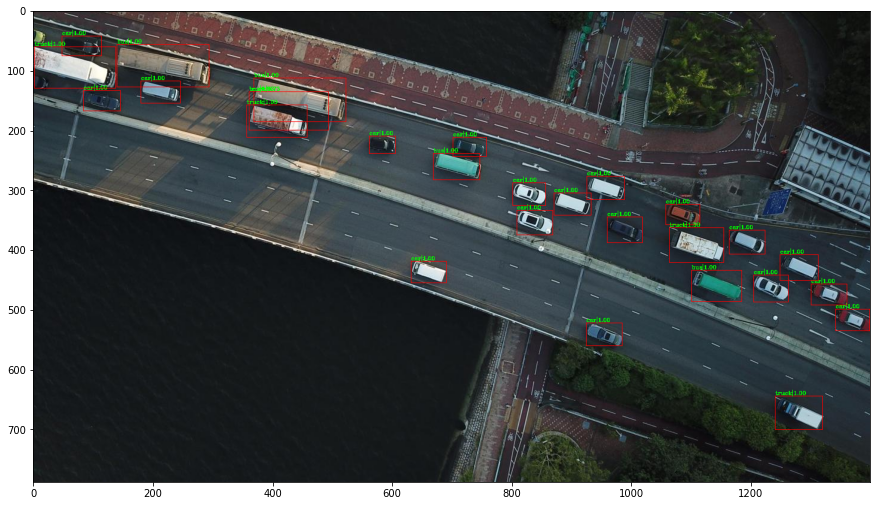

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

img = mmcv.imread('testImages/test3.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


# 分析训练日志

plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss_cls


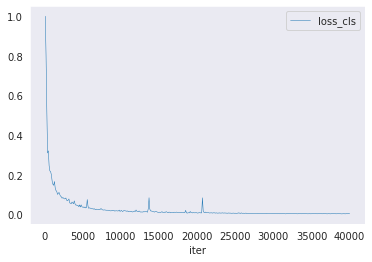

In [6]:
#绘制分类损失
%run tools/analyze_logs.py plot_curve ./work_dirs/retinanet_ms/None.log.json --keys loss_cls --legend loss_cls

plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss_bbox


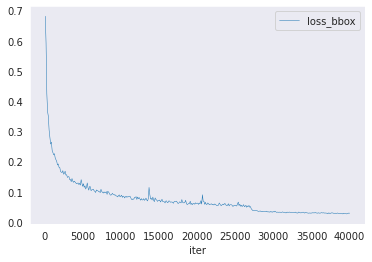

In [7]:
#回归损失
%run tools/analyze_logs.py plot_curve ./work_dirs/retinanet_ms/None.log.json --keys loss_bbox --legend loss_bbox

plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss


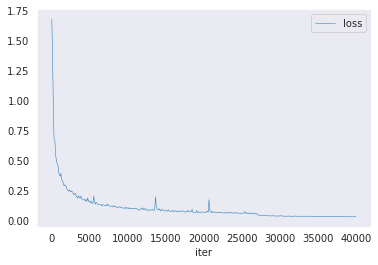

In [8]:
#总损失
%run tools/analyze_logs.py plot_curve ./work_dirs/retinanet_ms/None.log.json --keys loss --legend loss

plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss_cls
plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss_bbox
plot curve of ./work_dirs/retinanet_ms/None.log.json, metric is loss
save curve to: ./work_dirs/retinanet_ms/losses.pdf


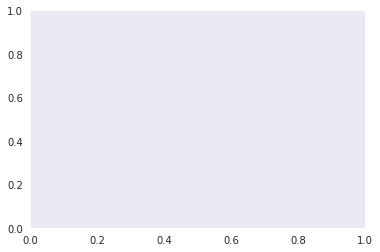

In [11]:
#多曲线保存为pdf输出
%run tools/analyze_logs.py plot_curve ./work_dirs/retinanet_ms/None.log.json --keys loss_cls loss_bbox loss --out ./work_dirs/retinanet_ms/losses.pdf
#%run tools/analyze_logs.py plot_curve ./work_dirs/retinanet/None.log.json --keys acc --out ./work_dirs/retinanet/acc.pdf

# 计算bbox/mAP

In [10]:
%run tools/test.py ./configs/retinanet/retinanet_r50_caffe_fpn_1x_coco.py ./work_dirs/retinanet_ms/latest.pth  --out out/aver.pkl --eval bbox --show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 0.3 task/s, elapsed: 221s, ETA:     0s
writing results to out/aver.pkl

Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.48s).
Accumulating evaluation results...
DONE (t=0.06s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.713
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.588
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.266
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.571
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.530
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
Average Recall 